<a href="https://colab.research.google.com/github/jayatigupta05/custom-dataset-food-cnn/blob/main/pytorch_custom_datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 0. Device agnostic code

In [ ]:
import torch
from torch import nn

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
!nvidia-smi

Fri Aug 22 12:23:30 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   63C    P8             11W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## 1. Getting data

In [ ]:
import requests
import zipfile
from pathlib import Path

data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

if image_path.is_dir():
  print(f"{image_path} directory already exists")
else:
  print(f"{image_path} does not exist")
  image_path.mkdir(parents=True, exist_ok=True)

with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  print("Downloading...")
  f.write(request.content)

# Unzip
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
  print("Unzipping...")
  zip_ref.extractall(image_path)

print("Done!")

data/pizza_steak_sushi does not exist
Downloading...
Unzipping...
Done!


In [ ]:
data_path, image_path

(PosixPath('data'), PosixPath('data/pizza_steak_sushi'))

## 2. Data preperation

In [ ]:
import os
def walkthrough_dir(dir_path):
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")

In [ ]:
walkthrough_dir(image_path)

There are 2 directories and 0 images in data/pizza_steak_sushi
There are 3 directories and 0 images in data/pizza_steak_sushi/train
There are 0 directories and 75 images in data/pizza_steak_sushi/train/steak
There are 0 directories and 78 images in data/pizza_steak_sushi/train/pizza
There are 0 directories and 72 images in data/pizza_steak_sushi/train/sushi
There are 3 directories and 0 images in data/pizza_steak_sushi/test
There are 0 directories and 19 images in data/pizza_steak_sushi/test/steak
There are 0 directories and 25 images in data/pizza_steak_sushi/test/pizza
There are 0 directories and 31 images in data/pizza_steak_sushi/test/sushi


In [ ]:
# setup train and test path
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

### 2.1 Visualise data

Image path: data/pizza_steak_sushi/train/pizza/2291093.jpg
Image class: pizza
Image size: (512, 512)
Image mode: RGB
Image format: JPEG


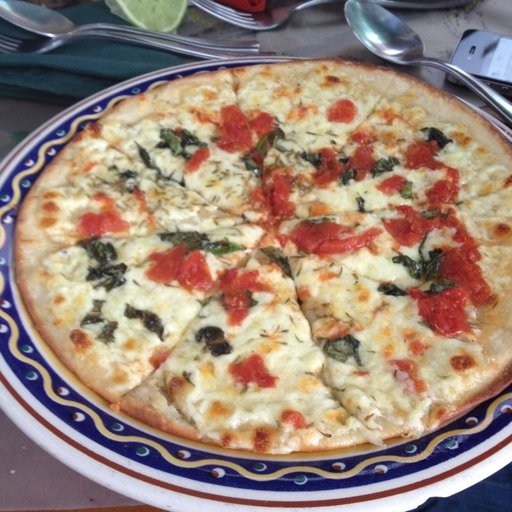

In [ ]:
import random
from PIL import Image

# random.seed(42)

# 1. Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Pick random image
rand_img_path = random.choice(image_path_list)

# 3. Get image class (from directory name)
image_class =  rand_img_path.parent.stem

# 4. Open image
img = Image.open(rand_img_path)

# 5. Print metadata
print(f"Image path: {rand_img_path}")
print(f"Image class: {image_class}")
print(f"Image size: {img.size}")
print(f"Image mode: {img.mode}")
print(f"Image format: {img.format}")
img

In [ ]:
rand_img_path.parent, rand_img_path, rand_img_path.parent.stem

(PosixPath('data/pizza_steak_sushi/train/pizza'),
 PosixPath('data/pizza_steak_sushi/train/pizza/2291093.jpg'),
 'pizza')

(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

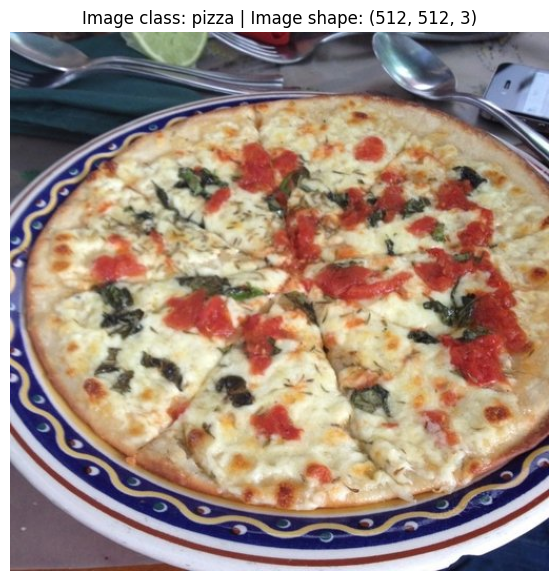

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

img_as_arr = np.asarray(img)

plt.figure(figsize=(10,7))
plt.imshow(img_as_arr)
plt.title(f"Image class: {image_class} | Image shape: {img_as_arr.shape}")
plt.axis(False)

In [ ]:
img, img_as_arr

(<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x512>,
 array([[[156, 195, 226],
         [152, 191, 222],
         [142, 183, 213],
         ...,
         [142, 142, 152],
         [140, 140, 150],
         [137, 137, 147]],
 
        [[184, 221, 250],
         [179, 218, 247],
         [173, 212, 241],
         ...,
         [144, 144, 154],
         [143, 143, 153],
         [142, 142, 152]],
 
        [[192, 228, 254],
         [191, 227, 253],
         [190, 226, 252],
         ...,
         [144, 144, 154],
         [145, 145, 155],
         [145, 145, 155]],
 
        ...,
 
        [[134, 105, 107],
         [134, 105, 107],
         [133, 104, 106],
         ...,
         [ 21,  33,  73],
         [ 21,  33,  73],
         [ 19,  31,  71]],
 
        [[127,  96,  94],
         [126,  95,  93],
         [126,  95,  93],
         ...,
         [ 21,  33,  73],
         [ 21,  33,  73],
         [ 19,  31,  71]],
 
        [[104,  70,  68],
         [103,  69,  67],
  

## 3. Transforming data

In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### 3.1 Transforming data

In [ ]:
data_transform = transforms.Compose([
  transforms.Resize((64,64)),
  transforms.ToTensor(),
  transforms.RandomHorizontalFlip(p=0.5)
])

In [ ]:
def plot_transformed_images(image_paths, transform, n=3, seed=None):
  if seed:
    random.seed(seed)
  random_image_paths = random.sample(image_paths, k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows=1, ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original\nSize: {f.size}")
      ax[0].axis(False)

      transformed_image = transform(f).permute(1, 2, 0)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed\nSize: {transformed_image.shape}")
      ax[1].axis("off")

      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

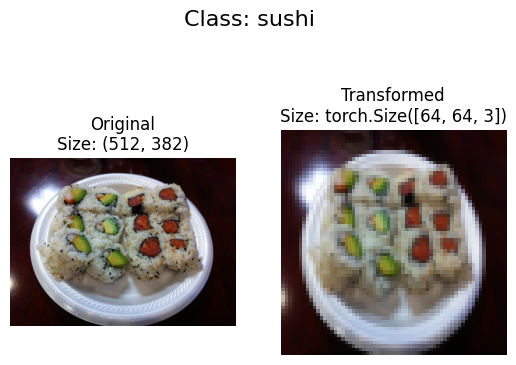

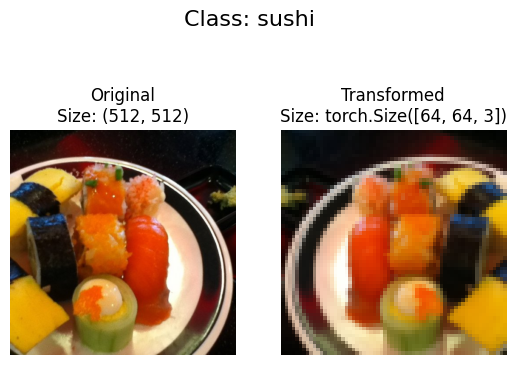

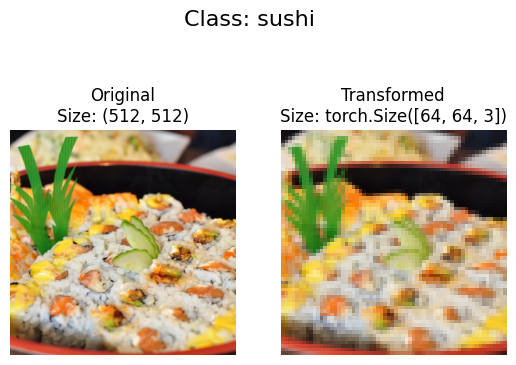

In [ ]:
plot_transformed_images(image_paths=image_path_list,
                        transform=data_transform,
                        n=3)

## 4. Loading Image Data using `ImageFolder`

### 4.1 Making train and test data

In [ ]:
from torchvision import datasets

train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform,
                                  target_transform=None)

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
                RandomHorizontalFlip(p=0.5)
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
                RandomHorizontalFlip(p=0.5)
            ))

In [ ]:
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [ ]:
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [ ]:
len(test_data), len(train_data)

(75, 225)

torch.float32


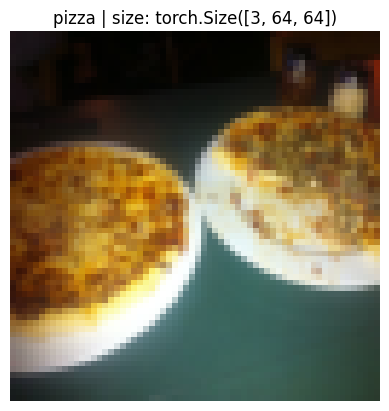

In [ ]:
img, label = train_data[0][0], train_data[0][1]
img.shape
# plt.figure(figsize=(10, 7))
plt.imshow(img.permute(1, 2, 0))
plt.title(f"{class_names[label]} | size: {img.shape}")
plt.axis("off")
print(img.dtype)

### 4.2 Making DataLoaders

In [ ]:
import os
os.cpu_count()

2

In [ ]:
from torch.utils.data import DataLoader
BATCH_SIZE = 1
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE, shuffle=True,
                              num_workers=1)

test_dataloader = DataLoader(dataset=test_data,
                             shuffle=False,
                             batch_size=BATCH_SIZE,
                             num_workers=1)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x79f5ffe2ffb0>,
 <torch.utils.data.dataloader.DataLoader at 0x79f6103377d0>)

In [ ]:
img, label = next(iter(train_dataloader))
img.shape, label.shape

(torch.Size([1, 3, 64, 64]), torch.Size([1]))

In [ ]:
len(train_dataloader), len(train_data)

(225, 225)

## 5. Loading image data with a custom `Dataset`
Needs:
1. Load images from file
2. Get class names from Dataset
3. Get classes as dict from Dataset

In [ ]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [ ]:
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.1 Creating helper function to get class names
Needs:
1. Get class names `os.scandir()` to transverse target directory
2. Raise error if the class names aren't found
3. Turn the class names into a dict and a list nd return them

In [ ]:
# setup path for target dir
target_dir = train_dir
print(f"Target dir: {target_dir}")

# get the class names from the target directory
class_names_found = sorted(item.name for item in list(os.scandir(target_dir)))
print(f"Class names: {class_names_found}")

Target dir: data/pizza_steak_sushi/train
Class names: ['pizza', 'steak', 'sushi']


In [ ]:
list(os.scandir(test_dir))

[<DirEntry 'steak'>, <DirEntry 'pizza'>, <DirEntry 'sushi'>]

In [ ]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
  # 1. Get the class names by scanning the tearget dir
  classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

  # 2. Raise error if class names not found
  if not classes:
    raise FileNotFoundError(f"Couldnt find any classes in {directory}")

  # 3. Create a dict of index labels
  class_to_idx = {cls: idx for idx, cls in enumerate(classes)}
  return classes, class_to_idx

In [ ]:
find_classes(target_dir)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

In [ ]:
sample_data = Path("/content")
find_classes(sample_data)

(['.config', 'data', 'sample_data'],
 {'.config': 0, 'data': 1, 'sample_data': 2})

### 5.2 Create custom `Dataset` to replicate `ImageFolder`
Need:
1. Subclass `torch.utils.data.Dataset`
2. Init subclass with a target dir
3. Create several attributes:
 * paths
 * transform
 * classes
 * class_to_idx
4. Create a function `load_images()` to open an image
5. Overwrite the `__len()__` method to return the length of the dataset
6. Overwrite the `__getitem()__` method to retirn a given sample when passed an index

In [ ]:
from torch.utils.data import Dataset

# 1. Suclass torch.util.data.Dataset
class ImageFolderCustom(Dataset):

  # 2. Init with target_dir and transform
  def __init__(self, target_dir: str, transform=None) -> None:

    # 3. Create class attr
    self.paths = list(pathlib.Path(target_dir).glob("*/*.jpg"))
    self.transform = transform
    self.classes, self.class_to_idx = find_classes(target_dir)

  # 4. Make func to load images
  def load_image(self, index: int) -> Image.Image:
    image_path = self.paths[index]
    return Image.open(image_path)

  # 5. Overwrite __len()__ method
  def __len__(self) -> int:
    return len(self.paths)

  def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
    image = self.load_image(index)
    class_name = self.paths[index].parent.stem
    class_idx = self.class_to_idx[class_name]

    if self.transform:
      return self.transform(image), class_idx
    else:
      return img, class_idx

In [ ]:
train_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

In [ ]:
train_data_custom = ImageFolderCustom(target_dir=train_dir,
                                      transform=train_transforms)

test_data_custom = ImageFolderCustom(target_dir=test_dir,
                                     transform=test_transforms)

train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x79f5ffece9f0>,
 <__main__.ImageFolderCustom at 0x79f61019fda0>)

In [ ]:
len(train_data_custom), len(test_data_custom)

(225, 75)

In [ ]:
train_data_custom.classes, train_data_custom.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.3 Function to display random images

In [ ]:
import random
def display_random_images(dataset: torch.utils.data.Dataset,
                          classes: List[str],
                          n: int = 10,  # number of images to display
                          display_shape: bool = True,
                          seed: int = None):
  if n > 10:
    n = 10
    display_shape = False
    print("Number of images should be lesser than 10")

  if seed:
    random.seed(seed)

  random_samples_idx = random.sample(range(len(dataset)), k=n)

  plt.figure(figsize=(16, 8))

  for i, targ_sample in enumerate(random_samples_idx):
    img, label = dataset[targ_sample][0], dataset[targ_sample][1]
    img_adjust = img.permute(1, 2, 0)
    plt.subplot(1, n, i+1)
    plt.imshow(img_adjust)
    plt.axis("off")
    if classes:
      title = f"Class = {classes[label]}"
      if display_shape:
        title += f"\nshape = {img.shape}"
    plt.title(title)

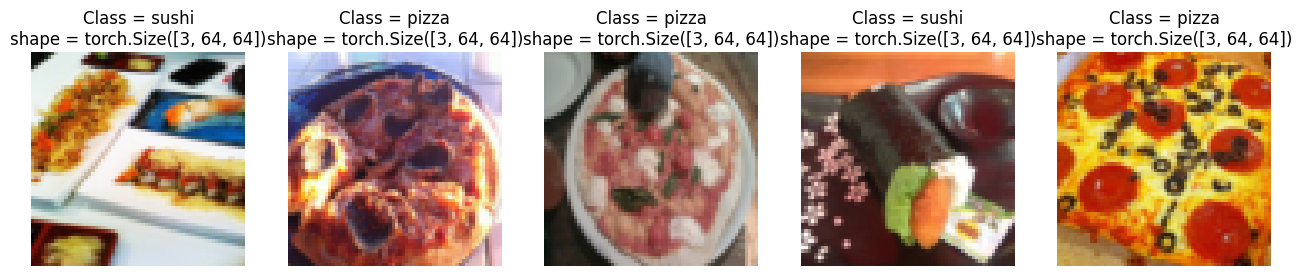

In [ ]:
# Display random images from ImageFolder created Dataset
display_random_images(train_data,
                      n=5,
                      classes=class_names,
                      seed=42)

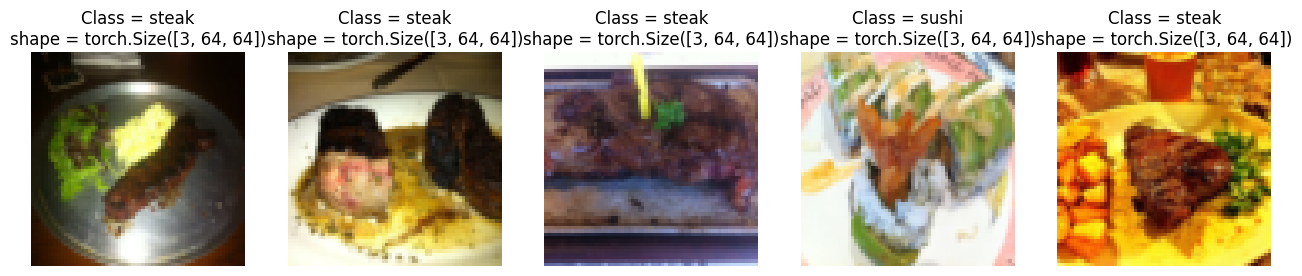

In [ ]:
# Display random images from ImageFolder created Dataset
display_random_images(train_data_custom,
                      n=5,
                      classes=class_names,
                      seed=None)

### 5.4 Making dataloaders

In [ ]:
from torch.utils.data import DataLoader

BATCH_SIZE = 1
train_dataloader_custom = DataLoader(dataset=train_data_custom,
                                     batch_size=BATCH_SIZE,
                                     shuffle=True,
                                     num_workers=1)

test_dataloader_custom = DataLoader(dataset=test_data_custom,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=1)

train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x79f5ff813980>,
 <torch.utils.data.dataloader.DataLoader at 0x79f5ffc71280>)

In [ ]:
img, label = next(iter(train_dataloader_custom))
img.shape, label.shape

(torch.Size([1, 3, 64, 64]), torch.Size([1]))

## 6. Data augmentation

Artificially adding diversity to data

In [ ]:
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.Resize(size=(224, 244)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor()
])

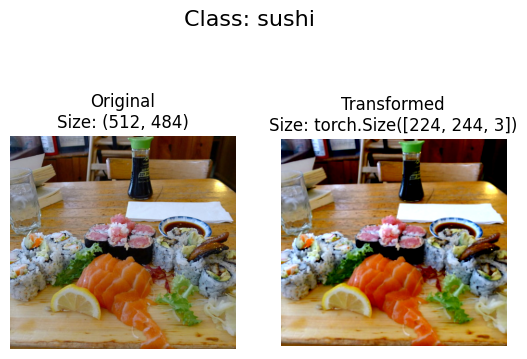

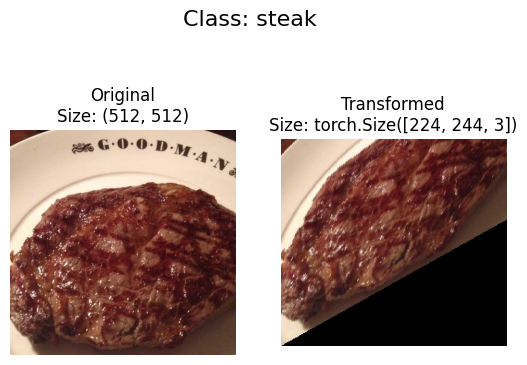

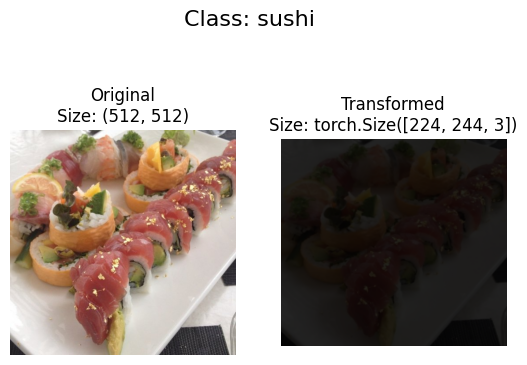

In [ ]:
plot_transformed_images(image_paths=image_path_list,
                        transform=train_transform,
                        n=3,
                        seed=None)

## 7. Model 0: TinyVGG architecture

In [ ]:
# create simple transform
simple_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

In [ ]:
# 1. Load and transform data
from torchvision import datasets
train_data_simple = datasets.ImageFolder(root=train_dir,
                                         transform=simple_transform,
                                         target_transform=None)

test_data_simple = datasets.ImageFolder(root=test_dir,
                                        transform=simple_transform)

# 2. Turn datasets into DataLoaders
import os
from torch.utils.data import DataLoader

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

train_dataloader_simple = DataLoader(dataset=train_data_simple,
                                     batch_size=BATCH_SIZE,
                                     shuffle=True,
                                     num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=NUM_WORKERS)

### 7.2 TinyVGG model class

In [ ]:
class tinyvgg(nn.Module):
  def __init__(self, input_shape: int,
               hidden_units: int,
               output_shape: int):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2)
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2)
    )
    self.output_layer = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*13*13,
                  out_features=output_shape)
    )

  def forward(self, x):
    x = self.conv_block_1(x)
    # print(x.shape)
    x = self.conv_block_2(x)
    # print(x.shape)
    x = self.output_layer(x)
    # print(x.shape)
    return x
    # return self.classifier(self.conv_block_2(self.conv_block_1(x))) # benefits operator fusion - reduces gpu process time

In [ ]:
torch.manual_seed(42)
model_0 = tinyvgg(input_shape=3,
                  hidden_units=10,
                  output_shape=len(train_data_simple.classes)).to(device)

model_0

tinyvgg(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (output_layer): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

### 7.3 Try forward pass on single image

In [ ]:
image_batch, label_batch = next(iter(train_dataloader_simple))
image_batch.shape, label_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

Text(0.5, 1.0, 'pizza')

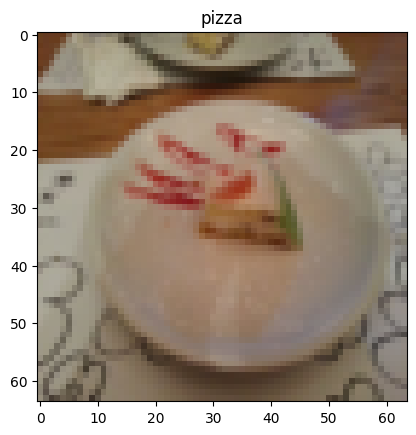

In [ ]:
model_0.eval()
with torch.inference_mode():
  pred = model_0(image_batch.to(device))
plt.imshow(image_batch[0].permute(1, 2, 0))
plt.title(class_names[pred.argmax(dim=1)[0]])

#### Getting detailed info on shape and model

In [ ]:
!pip install torchinfo

In [ ]:
from torchinfo import summary
summary(model_0, input_size=(1, 3, 64, 64))

Layer (type:depth-idx)                   Output Shape              Param #
tinyvgg                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─ReLU: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia

### 7.5 Train and test loops

In [ ]:
def train_step(model: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               loss_fn: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader):
  model.train()
  train_loss, train_acc = 0, 0
  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)
    y_pred = model(X)
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += (y_pred_class == y).sum().item()/len(y_pred_class)
  train_loss /= len(dataloader)
  train_acc /= len(dataloader)
  return train_loss, train_acc

In [ ]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
  model.eval()
  test_loss, test_acc = 0, 0
  with torch.inference_mode():
    for X, y in dataloader:
      X, y = X.to(device), y.to(device)
      test_pred = model(X)
      loss = loss_fn(test_pred, y)
      test_loss += loss.item()
      test_pred_class = torch.argmax(torch.softmax(test_pred, dim=1), dim=1)
      test_acc += (test_pred_class == y).sum().item()/len(test_pred_class)
    test_loss /= len(dataloader)
    test_acc /= len(dataloader)
    return test_loss, test_acc

### 7.6 Train loop to combine it all

In [ ]:
from tqdm.auto import tqdm
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):

  # 1. Make empty result dict
  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}

  # 2. Loop through steps
  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model=model,
                                       dataloader=train_dataloader,
                                       optimizer=optimizer,
                                       loss_fn=loss_fn)
    test_loss, test_acc = test_step(model=model,
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn)

    # 3. Print progress
    print(
        f"Epoch: {epoch+1} | "
        f"Trainloss: {train_loss:.4f} | "
        f"Train acc: {train_acc:.2f}% | "
        f"Test loss: {test_loss:.4f} | "
        f"Test acc: {test_acc:.2f}%"
    )

    # 4. Update results dictionary
    # Ensure all data is moved to CPU and converted to float for storage
    results["train_loss"].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
    results["train_acc"].append(train_acc.item() if isinstance(train_acc, torch.Tensor) else train_acc)
    results["test_loss"].append(test_loss.item() if isinstance(test_loss, torch.Tensor) else test_loss)
    results["test_acc"].append(test_acc.item() if isinstance(test_acc, torch.Tensor) else test_acc)

  return results

### 7.7 Train and evalute model 0

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

EPOCHS = 5

model_0 = tinyvgg(input_shape=3,
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device)

loss_fn = nn.CrossEntropyLoss()
optmizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)


from timeit import default_timer as timer

start = timer()
modle_0_results = train(model=model_0,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optmizer,
                        loss_fn=loss_fn,
                        epochs=EPOCHS)
end = timer()
print(f"Total training time: {end-start:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | Trainloss: 1.1007 | Train acc: 0.35% | Test loss: 1.0863 | Test acc: 0.44%
Epoch: 2 | Trainloss: 1.0361 | Train acc: 0.50% | Test loss: 1.0427 | Test acc: 0.43%
Epoch: 3 | Trainloss: 1.0073 | Train acc: 0.55% | Test loss: 1.0078 | Test acc: 0.51%
Epoch: 4 | Trainloss: 0.9535 | Train acc: 0.58% | Test loss: 0.9894 | Test acc: 0.48%
Epoch: 5 | Trainloss: 0.9564 | Train acc: 0.56% | Test loss: 0.9756 | Test acc: 0.49%
Total training time: 18.022 seconds


### 7.8 Plot loss curves

In [ ]:
modle_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [ ]:
def plot_loss_curves(results: Dict[str, List[float]]):
  loss = results["train_loss"]
  test_loss = results["test_loss"]
  accuracy = results["train_acc"]
  test_accuracy = results["test_acc"]

  epochs = range(len(results["train_loss"]))

  # loss plot
  plt.figure(figsize=(15, 7))
  plt.subplot(1, 2, 1)
  plt.plot(epochs, loss, label="train_loss")
  plt.plot(epochs, test_loss, label="test_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # accuracy plot
  plt.subplot(1, 2, 2)
  plt.plot(epochs, accuracy, label="train_accuracy")
  plt.plot(epochs, test_accuracy, label="test_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()

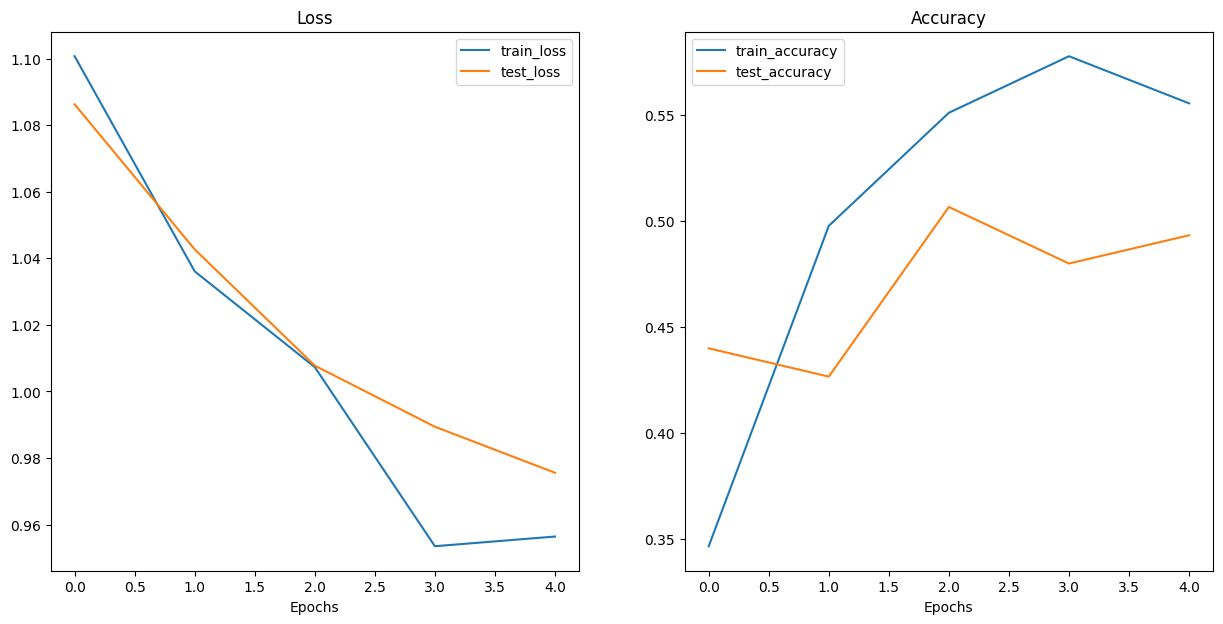

In [ ]:
plot_loss_curves(modle_0_results)

## 8. Model 1: TinyVGG with data aumentation

In [ ]:
train_transform_aug = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

### 8.1 Making train and test dataset and dataloader

In [ ]:
train_data_aug = datasets.ImageFolder(train_dir, transform=train_transform_aug)
test_data_simple = datasets.ImageFolder(test_dir, transform=test_transform)

train_data_aug, test_data_simple

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ))

In [ ]:
import os

train_dataloader_aug = DataLoader(train_data_aug,
                                 batch_size=32,
                                 shuffle=True,
                                 num_workers=os.cpu_count())

test_dataloader_simple = DataLoader(test_data_simple,
                                    batch_size=32,
                                    shuffle=False,
                                    num_workers=os.cpu_count())

In [ ]:
train_dataloader_aug, test_dataloader_simple

(<torch.utils.data.dataloader.DataLoader at 0x79f5ff811bb0>,
 <torch.utils.data.dataloader.DataLoader at 0x79f5ffca98b0>)

### 8.2 Constructing model 1

In [ ]:
torch.manual_seed(42)
model_1 = tinyvgg(input_shape=3,
                  hidden_units=10,
                  output_shape=len(train_data_aug.classes)).to(device)

model_1

tinyvgg(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (output_layer): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

### 8.3 Training model

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

EPOCHS = 5

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.001)

from timeit import default_timer as timer
start = timer()
model_1_results = train(model=model_1,
                        train_dataloader=train_dataloader_aug,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=EPOCHS)
end = timer()
print(f"Time taken: {end-start}s")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | Trainloss: 1.1049 | Train acc: 0.25% | Test loss: 1.1019 | Test acc: 0.26%
Epoch: 2 | Trainloss: 1.0807 | Train acc: 0.43% | Test loss: 1.1261 | Test acc: 0.26%
Epoch: 3 | Trainloss: 1.0712 | Train acc: 0.43% | Test loss: 1.1592 | Test acc: 0.26%
Epoch: 4 | Trainloss: 1.1254 | Train acc: 0.30% | Test loss: 1.1581 | Test acc: 0.26%
Epoch: 5 | Trainloss: 1.0859 | Train acc: 0.43% | Test loss: 1.1552 | Test acc: 0.33%
Time taken: 13.232953049000002s


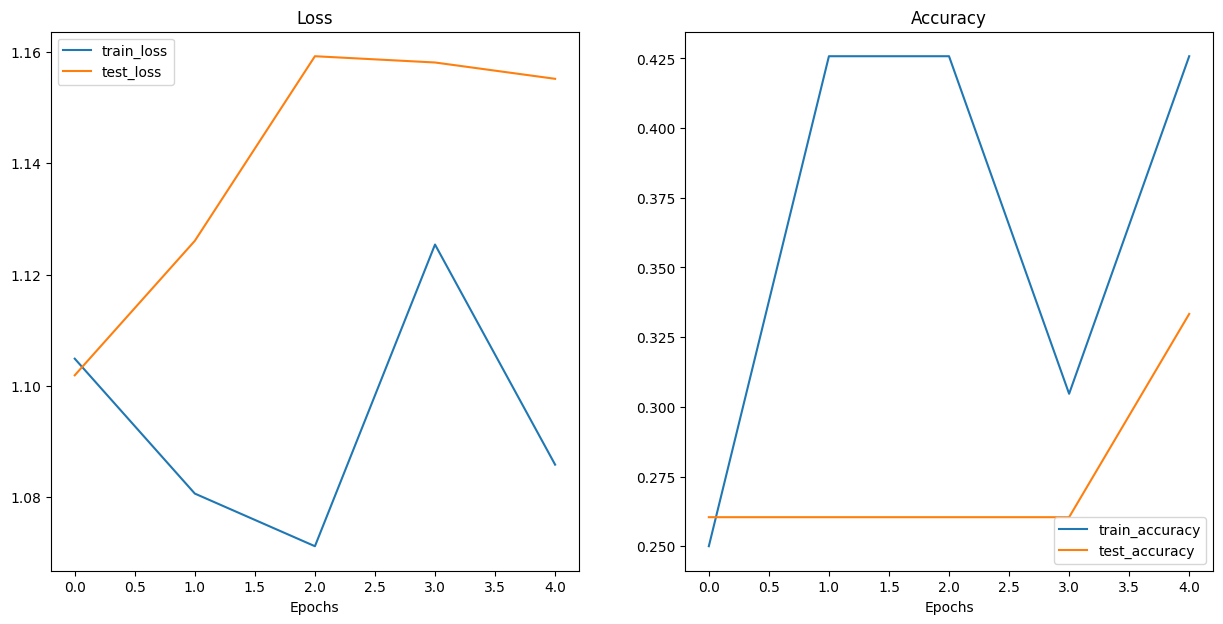

In [ ]:
plot_loss_curves(model_1_results)

## 9. Comparing results

In [ ]:
import pandas as pd
model_0_df = pd.DataFrame(modle_0_results)
model_1_df = pd.DataFrame(model_1_results)

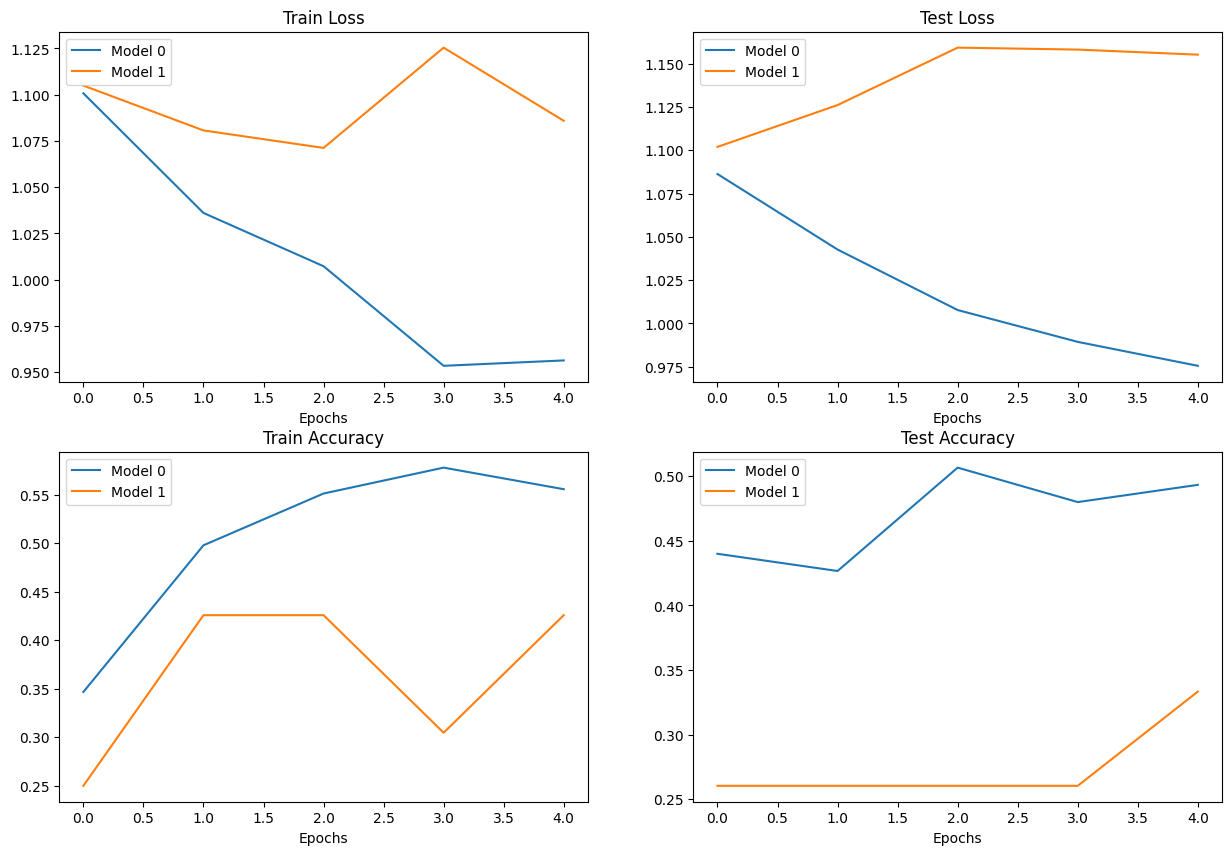

In [ ]:
# Setup a plot
plt.figure(figsize=(15, 10))

# Get number of epochs
epochs = range(len(model_0_df))

# Plot train loss
plt.subplot(2, 2, 1)
plt.plot(epochs, model_0_df["train_loss"], label="Model 0")
plt.plot(epochs, model_1_df["train_loss"], label="Model 1")
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot test loss
plt.subplot(2, 2, 2)
plt.plot(epochs, model_0_df["test_loss"], label="Model 0")
plt.plot(epochs, model_1_df["test_loss"], label="Model 1")
plt.title("Test Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot train accuracy
plt.subplot(2, 2, 3)
plt.plot(epochs, model_0_df["train_acc"], label="Model 0")
plt.plot(epochs, model_1_df["train_acc"], label="Model 1")
plt.title("Train Accuracy")
plt.xlabel("Epochs")
plt.legend()

# Plot test accuracy
plt.subplot(2, 2, 4)
plt.plot(epochs, model_0_df["test_acc"], label="Model 0")
plt.plot(epochs, model_1_df["test_acc"], label="Model 1")
plt.title("Test Accuracy")
plt.xlabel("Epochs")
plt.legend();

## 10. Making a prediction

In [ ]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = data_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

In [ ]:
data_path, custom_image_path

(PosixPath('data'), PosixPath('data/04-pizza-dad.jpeg'))

### 10.1 Loading custom image

In [ ]:
# /content/data/04-pizza-dad.jpeg

In [ ]:
import torchvision

# Read in custom image
custom_image_uint8 = torchvision.io.read_image(str(custom_image_path))

# Print out image data
print(f"Custom image tensor:\n{custom_image_uint8}\n")
print(f"Custom image shape: {custom_image_uint8.shape}\n")
print(f"Custom image dtype: {custom_image_uint8.dtype}")

Custom image tensor:
tensor([[[154, 173, 181,  ...,  21,  18,  14],
         [146, 165, 181,  ...,  21,  18,  15],
         [124, 146, 172,  ...,  18,  17,  15],
         ...,
         [ 72,  59,  45,  ..., 152, 150, 148],
         [ 64,  55,  41,  ..., 150, 147, 144],
         [ 64,  60,  46,  ..., 149, 146, 143]],

        [[171, 190, 193,  ...,  22,  19,  15],
         [163, 182, 193,  ...,  22,  19,  16],
         [141, 163, 184,  ...,  19,  18,  16],
         ...,
         [ 55,  42,  28,  ..., 107, 104, 103],
         [ 47,  38,  24,  ..., 108, 104, 102],
         [ 47,  43,  29,  ..., 107, 104, 101]],

        [[119, 138, 147,  ...,  17,  14,  10],
         [111, 130, 145,  ...,  17,  14,  11],
         [ 87, 111, 136,  ...,  14,  13,  11],
         ...,
         [ 35,  22,   8,  ...,  52,  52,  48],
         [ 27,  18,   4,  ...,  50,  49,  44],
         [ 27,  23,   9,  ...,  49,  46,  43]]], dtype=torch.uint8)

Custom image shape: torch.Size([3, 4032, 3024])

Custom image dty

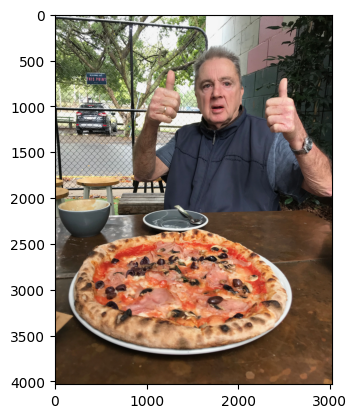

In [ ]:
plt.imshow(custom_image_uint8.permute(1, 2, 0))

### 10.2 Making the prediction

In [ ]:
# Transform image to match shape
from torchvision import transforms
custom_image_trans = transforms.Compose([transforms.Resize(size=(64, 64))])

custom_image_transformed = custom_image_trans(custom_image_uint8)
custom_image = custom_image_transformed.float().unsqueeze(dim=0)
custom_image.shape, custom_image.dtype

(torch.Size([1, 3, 64, 64]), torch.float32)

(np.float64(-0.5), np.float64(63.5), np.float64(63.5), np.float64(-0.5))

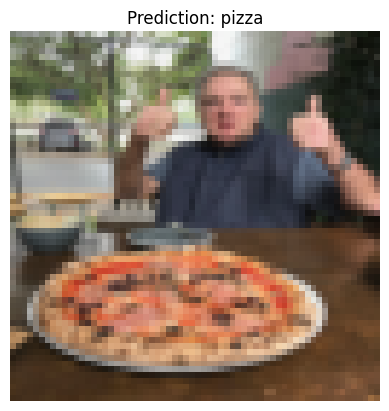

In [ ]:
model_1.eval()
with torch.inference_mode():
  custom_image_pred = model_1(custom_image.to(device))

plt.imshow(custom_image_transformed.permute(1, 2, 0))
plt.title(f"Prediction: {class_names[custom_image_pred.argmax()]}")
plt.axis(False)

### 10.3 Functionising custom image predictions

In [ ]:
def pred_and_plot_img(model: torch.nn.Module,
                      image_path: str,
                      class_names: List[str] = None,
                      transform=None,
                      device=device):
  target_img = torchvision.io.read_image(str(image_path)).float()
  # target_img /= 255
  # if transform:
  #   target_image = transform(target_img)
  transform = transforms.Compose([transforms.Resize(size=(64, 64))])
  target_img_trans = transform(target_img)
  model.to(device)
  model.eval()
  with torch.inference_mode():
    target_pred = model(target_img_trans.unsqueeze(dim=0).to(device))
  target_img_pred_prob = torch.softmax(target_pred, dim=1)
  target_img_pred_label = torch.argmax(target_img_pred_prob, dim=1)
  plt.imshow(target_img.permute(1, 2, 0) / 255)
  plt.title(f"Prediction: {class_names[target_img_pred_label]}")
  plt.axis(False)
  plt.show()

In [ ]:
custom_image_path

PosixPath('data/04-pizza-dad.jpeg')

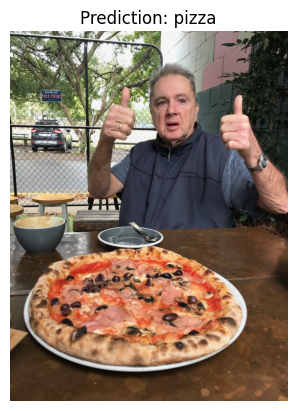

In [ ]:
pred_and_plot_img(model=model_1,
                  image_path=str(custom_image_path),
                  class_names=class_names,
                  transform=custom_image_trans,
                  device=device)